## Note
Version 1과 다른 점
- V1은 유튜브 데이터와 낚시성 요소가 없는 신문 기사를 학습함
- V2는 낚시성 영상과 비낚시성 영상의 자막 + 낚시성 기사와 비낚시성 기사를 동시에 학습

목적
- 도메인 불일치라는 내용을 충분히 학습(기존은 유튜브 영상만 학습하여 도메인 불일치라는 낚시성 영상의 형태를 못 잡아낼 수 있음)
- 학습 데이터에 노이즈 추가
- Over-confidence 방지

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [2]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 40.8 MB/s eta 0:00:00


### 0. 라이브러리

In [29]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchsummary import summary

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from peft import get_peft_model, LoraConfig, TaskType

In [4]:
# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fixSEED(seed=42)

In [6]:
# 디렉토리 설정
dir = 'YouTube_Text'
path = '/content/drive/MyDrive/Projects/Model/' + dir
os.chdir(path)
print(path)

/content/drive/MyDrive/Projects/Model/YouTube_Text


In [7]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 데이터 불러오기 및 가공

- 1번 : 유튜브 자막 데이터
- 2번 : AiHub 2000개 데이터

In [8]:
# Load data from a pickle file, and create labels
def callData(path: str):
    with open(path, "rb") as file:
        data = pickle.load(file)

    zero = data[data['label']==0]
    non_zero = data[data['label']==1]

    print(f'레이블 0 개수 : {len(zero)}')
    print(f'레이블 1 개수 : {len(non_zero)}')

    return data

In [11]:
# load data
aihub_data = callData("Data/AiHub_Sampled(2000).pkl")

레이블 0 개수 : 990
레이블 1 개수 : 992


In [12]:
# check
aihub_data.head()

,partNum,newsID,newsCategory,newsSubcategory,newsContent,processLevel,processPattern,contentList,sentenceCount,processSentencenum,useType,wordCount,label
270322,P2,PO_M08_568587,정치,외교.안보,한미 외교장관은 13일 윤석열정부 출범 후 첫 회담을 열고 북한의 핵실험 시 강력히...,하,99,[한미 외교장관은 13일 윤석열정부 출범 후 첫 회담을 열고 북한의 핵실험 시 강력...,7,2,0,165,1
230050,P2,SO_M07_673355,사회,전국,과천시 관문실내체육관이 개보수 작업에 들어간다. 개보수에 필요한 예산5700만원을 ...,상,24,"[과천시 관문실내체육관이 개보수 작업에 들어간다., 개보수에 필요한 예산5700만원...",7,2,0,106,1
148500,P2,ET_M03_502000,연예,연예가화제,슈가맨에서 미녀 작사가로 유명한 작사가 김이나가 유희열에게 못생겼다며 굴욕을 줘 화...,하,99,[슈가맨에서 미녀 작사가로 유명한 작사가 김이나가 유희열에게 못생겼다며 굴욕을 줘 ...,7,1,0,123,1
252824,P2,SO_M07_610123,사회,전국,충북도는 삼일절 기념행사에 앞서 오는 2월 28일 오후 충북도청 대회의실에서 3.1...,하,99,[충북도는 삼일절 기념행사에 앞서 오는 2월 28일 오후 충북도청 대회의실에서 3....,7,2,0,138,1
292630,P2,ET_M03_633082,연예,연예가화제,매일 아침마다 시끄러운 알람 소리에도 쉽게 잠이 깨지 않는 사람들을 위한 침대가 발...,중,22,[매일 아침마다 시끄러운 알람 소리에도 쉽게 잠이 깨지 않는 사람들을 위한 침대가 ...,7,4,0,109,1


In [19]:
# 유튜브 데이터 불러오기
youtube_data = callData('Data/youtubeData(8331)_with_label.pkl')

레이블 0 개수 : 5208
레이블 1 개수 : 3123


In [21]:
# concat two data
text1 = aihub_data['newsContent'] # 제목 미포함
text2 = youtube_data['content'] # 제목 미포함

label1 = aihub_data['label']
label2 = youtube_data['label']

data = pd.DataFrame({
    'text': pd.concat([text1, text2], ignore_index=True),
    'label': pd.concat([label1, label2], ignore_index=True)
})

In [ ]:
# 레이블 개수 확인
data['label'].value_counts()

### 2. Train/Valid/Test

In [23]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED)

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [24]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 6187개 
검증용 데이터 개수 : 2063개 
평가용 데이터 개수 : 2063개


### 3. Dataset 및 Dataloader 정의

In [45]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [46]:
# Dataset for YouTube mixed with AiHub
class MixedDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text'] # 자동생성자막과 기사 본문만
        label = self.data.iloc[idx]['label']

        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long) # 정수형

### 4. 모델 정의

In [47]:
class BaitingDetectBERT(nn.Module):
    def __init__(self, model_checkpoint, lora_r=8, lora_alpha=1, lora_dropout=0.1):
        super(BaitingDetectBERT, self).__init__()

        # Pre-trained Model
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

        # LoRA Config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            target_modules=["query", 'key', "value"],  # Apply LoRA to the attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )

        # Apply LoRA to Pre-trained Layers
        self.model = get_peft_model(self.model, lora_config)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
        return outputs

### 5. 학습용 Trainer 정의

In [49]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 100)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 100)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'▶️ Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./saved_models/Youtube/YouTube_RoBERTa_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'▶️ Model Saved to {save_path}')
                except Exception as e:
                    print(f'▶️ Model Not Saved: {e}')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'▶️▶️▶️ Early Stopping at Epoch {epoch+1} ◀️◀️◀️')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, y = batch
            input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, y = batch
                input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)


### 6. 학습 진행

In [50]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 64 # GPU 더 확보하면 128 시도

model_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [51]:
# 데이터셋 정의
train_dataset = MixedDataset(train_data, tokenizer, max_length)
valid_dataset = MixedDataset(valid_data, tokenizer, max_length)
test_dataset = MixedDataset(test_data, tokenizer, max_length)

In [52]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0, 20482,  2052,  ...,  2088,  1513,     2],
         [    0,  1526,  2114,  ...,  2753,  5034,     2],
         [    0,  3682,  7388,  ...,  2118,  2520,     2],
         ...,
         [    0,   746,  1637,  ...,    80,  2040,     2],
         [    0,  3753,  1663,  ..., 24588,  4612,     2],
         [    0,  7896,  2145,  ...,  2106,  2184,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
         1, 1, 0, 0, 1, 1, 1, 0])]

In [53]:
# Model
model = BaitingDetectBERT(model_checkpoint)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BaitingDetectBERT(
  (model): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): RobertaForSequenceClassification(
        (roberta): RobertaModel(
          (embeddings): RobertaEmbeddings(
            (word_embeddings): Embedding(32000, 1024, padding_idx=1)
            (position_embeddings): Embedding(514, 1024, padding_idx=1)
            (token_type_embeddings): Embedding(1, 1024)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): RobertaEncoder(
            (layer): ModuleList(
              (0-23): 24 x RobertaLayer(
                (attention): RobertaAttention(
                  (self): RobertaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, 

In [54]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 2231298 
All params: 338889732
--------------------------------------------------
Trainable(%): 0.65841


In [56]:
# 학습 파라미터
num_epochs = 20
wait_for_es = 5

In [55]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [57]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [58]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

----------------------------------------------------------------------------------------------------
Epoch 1/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  3.00it/s]


[Train] 	 Loss: 0.6429 	 Acc: 0.5996 	 Precision: 0.4958 	 Recall: 0.1659 	 F1: 0.1882
[Valid] 	 Loss: 0.5994 	 Acc: 0.6736 	 Precision: 0.6810 	 Recall: 0.3229 	 F1: 0.4271
▶️ Epoch 1 complete in 2m 12s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.6736.pth
----------------------------------------------------------------------------------------------------
Epoch 2/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.99it/s]


[Train] 	 Loss: 0.5682 	 Acc: 0.7042 	 Precision: 0.7216 	 Recall: 0.4430 	 F1: 0.5346
[Valid] 	 Loss: 0.5379 	 Acc: 0.7372 	 Precision: 0.7183 	 Recall: 0.5568 	 F1: 0.6142
▶️ Epoch 2 complete in 4m 29s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.7372.pth
----------------------------------------------------------------------------------------------------
Epoch 3/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.99it/s]


[Train] 	 Loss: 0.5112 	 Acc: 0.7573 	 Precision: 0.7359 	 Recall: 0.6352 	 F1: 0.6689
[Valid] 	 Loss: 0.4848 	 Acc: 0.7889 	 Precision: 0.7103 	 Recall: 0.7963 	 F1: 0.7437
▶️ Epoch 3 complete in 6m 45s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.7889.pth
----------------------------------------------------------------------------------------------------
Epoch 4/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]


[Train] 	 Loss: 0.4566 	 Acc: 0.7946 	 Precision: 0.7471 	 Recall: 0.7330 	 F1: 0.7311
[Valid] 	 Loss: 0.4351 	 Acc: 0.8094 	 Precision: 0.7303 	 Recall: 0.8255 	 F1: 0.7687
▶️ Epoch 4 complete in 9m 2s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8094.pth
----------------------------------------------------------------------------------------------------
Epoch 5/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  3.00it/s]


[Train] 	 Loss: 0.4173 	 Acc: 0.8088 	 Precision: 0.7586 	 Recall: 0.7757 	 F1: 0.7592
[Valid] 	 Loss: 0.4025 	 Acc: 0.8162 	 Precision: 0.7314 	 Recall: 0.8454 	 F1: 0.7790
▶️ Epoch 5 complete in 11m 18s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8162.pth
----------------------------------------------------------------------------------------------------
Epoch 6/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]


[Train] 	 Loss: 0.3880 	 Acc: 0.8203 	 Precision: 0.7718 	 Recall: 0.7824 	 F1: 0.7706
[Valid] 	 Loss: 0.3796 	 Acc: 0.8235 	 Precision: 0.7354 	 Recall: 0.8640 	 F1: 0.7888
▶️ Epoch 6 complete in 13m 35s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8235.pth
----------------------------------------------------------------------------------------------------
Epoch 7/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.97it/s]


[Train] 	 Loss: 0.3658 	 Acc: 0.8296 	 Precision: 0.7863 	 Recall: 0.7920 	 F1: 0.7820
[Valid] 	 Loss: 0.3582 	 Acc: 0.8330 	 Precision: 0.7631 	 Recall: 0.8345 	 F1: 0.7901
▶️ Epoch 7 complete in 15m 51s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8330.pth
----------------------------------------------------------------------------------------------------
Epoch 8/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.99it/s]


[Train] 	 Loss: 0.3485 	 Acc: 0.8378 	 Precision: 0.8065 	 Recall: 0.7956 	 F1: 0.7932
[Valid] 	 Loss: 0.3473 	 Acc: 0.8396 	 Precision: 0.7669 	 Recall: 0.8541 	 F1: 0.8025
▶️ Epoch 8 complete in 18m 8s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8396.pth
----------------------------------------------------------------------------------------------------
Epoch 9/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]


[Train] 	 Loss: 0.3399 	 Acc: 0.8426 	 Precision: 0.8051 	 Recall: 0.7992 	 F1: 0.7972
[Valid] 	 Loss: 0.3385 	 Acc: 0.8479 	 Precision: 0.7765 	 Recall: 0.8757 	 F1: 0.8162
▶️ Epoch 9 complete in 20m 24s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8479.pth
----------------------------------------------------------------------------------------------------
Epoch 10/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]


[Train] 	 Loss: 0.3265 	 Acc: 0.8455 	 Precision: 0.8144 	 Recall: 0.8072 	 F1: 0.8025
[Valid] 	 Loss: 0.3216 	 Acc: 0.8497 	 Precision: 0.8061 	 Recall: 0.8138 	 F1: 0.8050
▶️ Epoch 10 complete in 22m 41s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8497.pth
----------------------------------------------------------------------------------------------------
Epoch 11/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]


[Train] 	 Loss: 0.3188 	 Acc: 0.8504 	 Precision: 0.8175 	 Recall: 0.8149 	 F1: 0.8085
[Valid] 	 Loss: 0.3120 	 Acc: 0.8567 	 Precision: 0.8288 	 Recall: 0.8097 	 F1: 0.8117
▶️ Epoch 11 complete in 24m 58s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8567.pth
----------------------------------------------------------------------------------------------------
Epoch 12/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.96it/s]


[Train] 	 Loss: 0.3132 	 Acc: 0.8516 	 Precision: 0.8232 	 Recall: 0.8080 	 F1: 0.8067
[Valid] 	 Loss: 0.3095 	 Acc: 0.8559 	 Precision: 0.8251 	 Recall: 0.8226 	 F1: 0.8180
▶️ Epoch 12 complete in 27m 15s
----------------------------------------------------------------------------------------------------
Epoch 13/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:22<00:00,  2.95it/s]


[Train] 	 Loss: 0.3113 	 Acc: 0.8547 	 Precision: 0.8231 	 Recall: 0.8139 	 F1: 0.8129
[Valid] 	 Loss: 0.3041 	 Acc: 0.8642 	 Precision: 0.8504 	 Recall: 0.8004 	 F1: 0.8180
▶️ Epoch 13 complete in 29m 27s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8642.pth
----------------------------------------------------------------------------------------------------
Epoch 14/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:22<00:00,  2.89it/s]


[Train] 	 Loss: 0.3057 	 Acc: 0.8544 	 Precision: 0.8216 	 Recall: 0.8171 	 F1: 0.8144
[Valid] 	 Loss: 0.2991 	 Acc: 0.8642 	 Precision: 0.8262 	 Recall: 0.8390 	 F1: 0.8254
▶️ Epoch 14 complete in 31m 48s
----------------------------------------------------------------------------------------------------
Epoch 15/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:22<00:00,  2.90it/s]


[Train] 	 Loss: 0.2980 	 Acc: 0.8634 	 Precision: 0.8323 	 Recall: 0.8264 	 F1: 0.8239
[Valid] 	 Loss: 0.2935 	 Acc: 0.8731 	 Precision: 0.8492 	 Recall: 0.8335 	 F1: 0.8352
▶️ Epoch 15 complete in 34m 3s
▶️ Model Saved to ./saved_models/Youtube/YouTube_RoBERTa_ACC_0.8731.pth
----------------------------------------------------------------------------------------------------
Epoch 16/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.97it/s]


[Train] 	 Loss: 0.2957 	 Acc: 0.8570 	 Precision: 0.8249 	 Recall: 0.8235 	 F1: 0.8176
[Valid] 	 Loss: 0.2954 	 Acc: 0.8666 	 Precision: 0.8656 	 Recall: 0.7903 	 F1: 0.8192
▶️ Epoch 16 complete in 36m 22s
----------------------------------------------------------------------------------------------------
Epoch 17/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]


[Train] 	 Loss: 0.2913 	 Acc: 0.8596 	 Precision: 0.8294 	 Recall: 0.8217 	 F1: 0.8187
[Valid] 	 Loss: 0.2909 	 Acc: 0.8691 	 Precision: 0.8246 	 Recall: 0.8554 	 F1: 0.8343
▶️ Epoch 17 complete in 38m 34s
----------------------------------------------------------------------------------------------------
Epoch 18/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.99it/s]


[Train] 	 Loss: 0.2874 	 Acc: 0.8673 	 Precision: 0.8405 	 Recall: 0.8274 	 F1: 0.8276
[Valid] 	 Loss: 0.2862 	 Acc: 0.8716 	 Precision: 0.8333 	 Recall: 0.8516 	 F1: 0.8367
▶️ Epoch 18 complete in 40m 47s
----------------------------------------------------------------------------------------------------
Epoch 19/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  3.00it/s]


[Train] 	 Loss: 0.2827 	 Acc: 0.8675 	 Precision: 0.8371 	 Recall: 0.8303 	 F1: 0.8274
[Valid] 	 Loss: 0.2868 	 Acc: 0.8709 	 Precision: 0.8341 	 Recall: 0.8450 	 F1: 0.8346
▶️ Epoch 19 complete in 42m 60s
----------------------------------------------------------------------------------------------------
Epoch 20/20
----------------------------------------------------------------------------------------------------


Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]

[Train] 	 Loss: 0.2787 	 Acc: 0.8670 	 Precision: 0.8397 	 Recall: 0.8283 	 F1: 0.8277
[Valid] 	 Loss: 0.2830 	 Acc: 0.8729 	 Precision: 0.8515 	 Recall: 0.8285 	 F1: 0.8345
▶️ Epoch 20 complete in 45m 13s


In [64]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    fig = plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_acc_history, label='Train Precision')
    ax3.plot(valid_acc_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_acc_history, label='Train Recall')
    ax4.plot(valid_acc_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

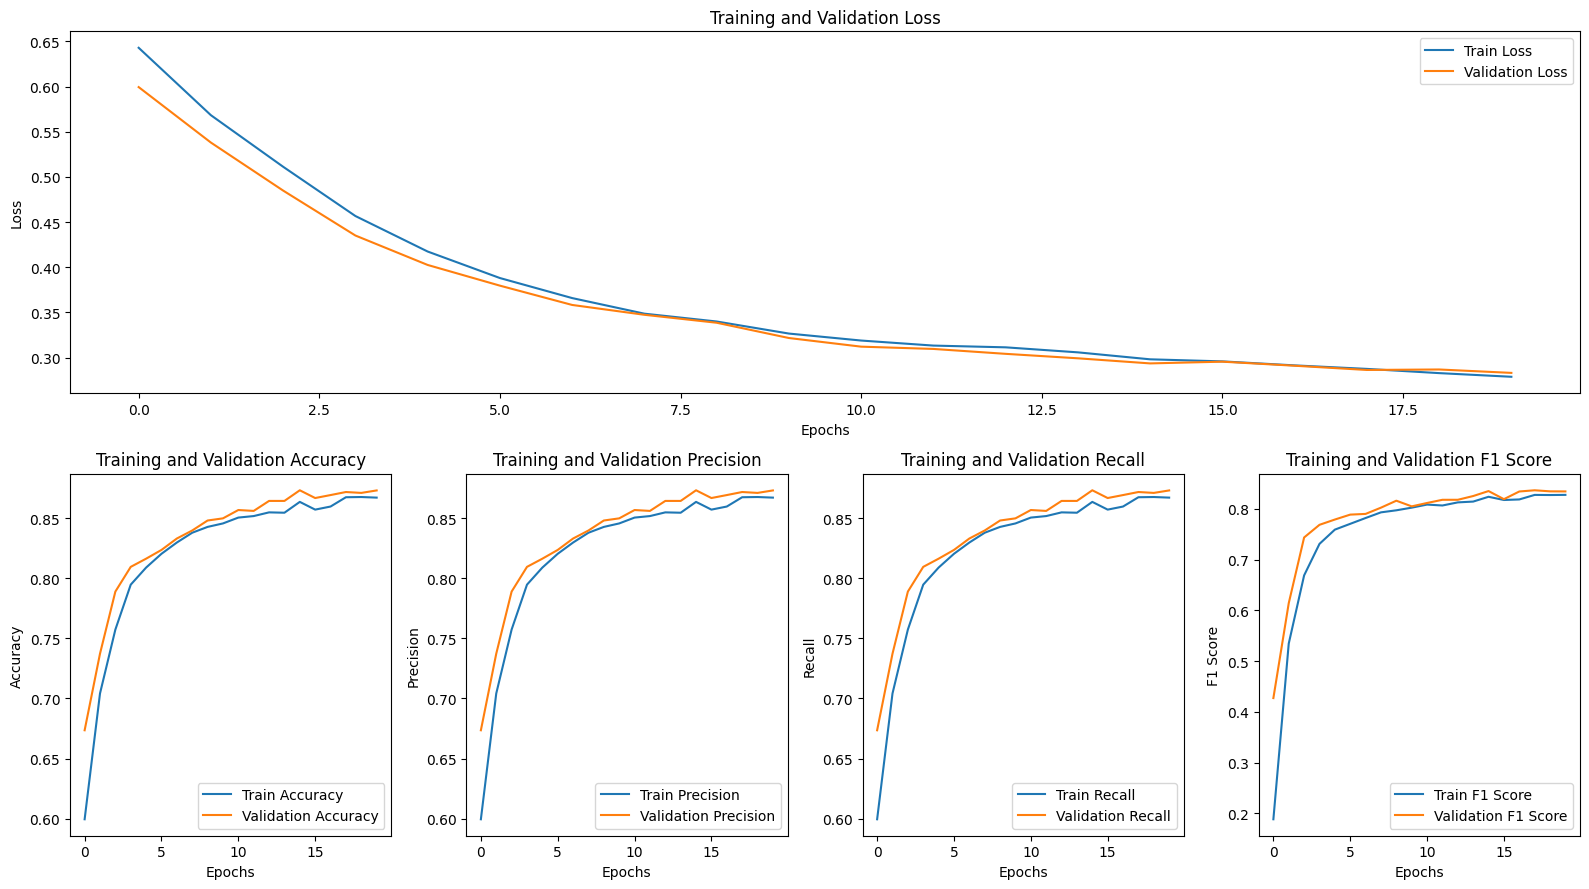

In [65]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

In [69]:
# 모델 로드 함수 정의
def load_model(model_path, model_checkpoint):
    model = BaitingDetectBERT(model_checkpoint)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [70]:
# 저장된 모델 경로
best_model_path = path+'/saved_models/Youtube/YouTube_RoBERTa_ACC_0.8731.pth'

In [71]:
# 모델 불러오기
model = load_model(best_model_path, model_checkpoint)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 65/65 [00:22<00:00,  2.90it/s]


In [73]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuracy: 0.8633
Test F1 Score: 0.8202
